# Part 1: Data Cleaning

### Load Packages and Set up Graph Parameters

In [1]:
%reset -f

import csv
import warnings
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt
import statsmodels.api   as sm

from scipy    import stats
from sklearn  import metrics
from datetime import time

from statsmodels.tsa               import stattools
from statsmodels.tsa.arima.model   import ARIMA
from statsmodels.tsa.stattools     import acf, pacf
from statsmodels.tsa.seasonal      import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
sns.mpl.rc('figure',figsize=(16, 6))

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
df = pd.read_csv('PRSA_data.csv')

In [3]:
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [4]:
df.columns = ['number', 'year', 'month', 'day', 'hour', 'pm25', 'dewp', 'temp', 'pres', 'cbwd', 'cws', 'cs', 'cr']

In [5]:
df['date'] = pd.to_datetime(df[['year','month','day','hour']])

In [6]:
# Setting DateTime index
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d-%h')
df.set_index('date', inplace=True)

### Functions

In [7]:
def seasonal_mean(df, season_var, con_var):
    """
    Generates the mean of the seasonal period of choice, plus the upper and lower Confidence Intervals
    
    df: DataFrame containing the data
    season_var: Seasonal categorical variable - day/hour/month
    con_var: Continuous variable providing the "mean" reading of interest
    n_sample: Number of samples for each mean reading
    
    """
    
    mean_dict = dict(df.groupby(season_var)[con_var].mean())
    
    n = df.groupby(season_var)[con_var].count().mean()
    
    upper_dict = dict(df.groupby(season_var)[con_var].mean() + 
                      1.96*(df.groupby(season_var)[con_var].std()/((n-1)**0.5)))
    
    lower_dict = dict(df.groupby(season_var)[con_var].mean() - 
                      1.96*(df.groupby(season_var)[con_var].std()/((n-1)**0.5)))
    
    mean_df = pd.DataFrame([mean_dict, upper_dict, lower_dict]).transpose()
    mean_df.columns = ['mean', 'upper_CI', 'lower_CI']
    
    return mean_df

In [8]:
def adf_statistics(series):
    """
    Function to output Augmented Dickey-Fuller test for stationarity
    
    series: Time series of interest
    """
    result = adfuller(series.values)
    
    print('ADF Statistic: %.4f' % result[0])
    print('p-value: %.4f' % result[1])
    
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.4f' % (key, value))
    if result[1] < 0.0500:
        print("Null hypothesis of non-stationarity is rejected")
    else:
        print("Null hypothesis of non-stationarity is NOT rejected")

In [9]:
def autocorr_plots(y, lags=20, alpha=0.05):
    """
    Function to plot autocorrelations and partial autocorrelations

    y: Time series data
    lags: Number of lags to plot
    alpha: Confidence level for random noise
    """
    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(y))
    
    fig, ax = plt.subplots(ncols=2, figsize=(18, 6), sharey=True)
    
    plot_acf(y, lags=lags, alpha=alpha, ax=ax[0], color='indigo')
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[0].set_title('Autocorrelation', fontsize=16)
    
    plot_pacf(y, lags=lags, alpha=alpha, ax=ax[1], method='ywmle', color='indigo')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[1].set_title('Partial Autocorrelation', fontsize=16)
    
    return fig, ax

### Target Variables

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   number  43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm25    41757 non-null  float64
 6   dewp    43824 non-null  int64  
 7   temp    43824 non-null  float64
 8   pres    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  cws     43824 non-null  float64
 11  cs      43824 non-null  int64  
 12  cr      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.7+ MB


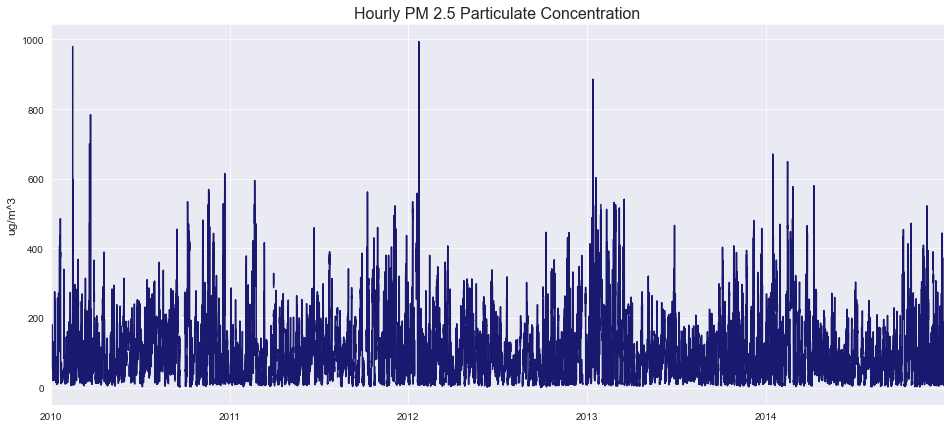

In [15]:
df['pm25'].plot(lw=1.5, color='midnightblue', figsize=(16, 7))
plt.title('Hourly PM 2.5 Particulate Concentration', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

In [16]:
df.describe()

,number,year,month,day,hour,pm25,dewp,temp,pres,cws,cs,cr
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


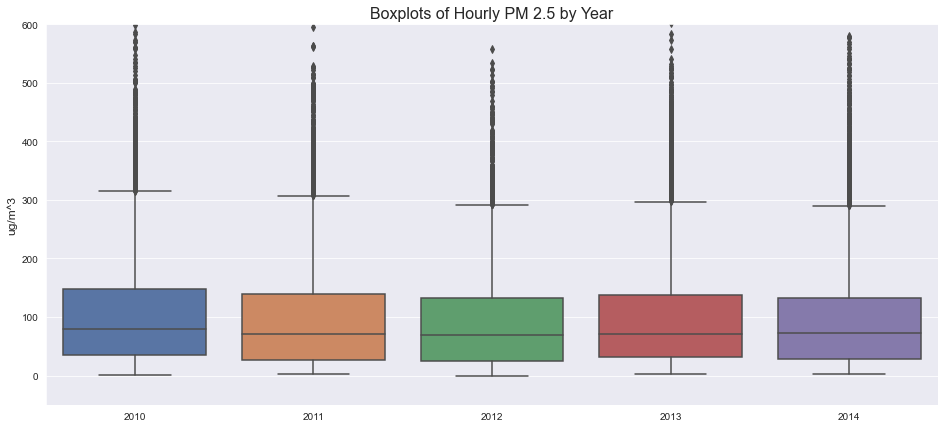

In [17]:
# Box-plots for 'PM 2.5' indicating no major trends in the distributions across the years
plt.figure(figsize=(16,7))

ax=sns.boxplot(x='year', y='pm25', data=df, orient='v', palette = sns.color_palette("deep", 5))
ax.set(ylim=(-50, 600))

plt.title('Boxplots of Hourly PM 2.5 by Year', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

#### There are no obvious difference in the distributions of the "PM 2.5" target variable across the years, though 2013/14 contain more right-side outliers than in 2011/12.

### Exploring Outliers in the Data

In [18]:
# There are 769 instances of 'pm25' being 3 std above the mean, or 1.75% of observations
df.pm25[(df.pm25 > np.mean(df.pm25) + 3*np.std(df.pm25))].count()

769

In [19]:
# There are 24 instances of 'factor01' being 6 std above the mean
df.pm25[(df.pm25 > np.mean(df.pm25) + 6*np.std(df.pm25))].count()

24

In [20]:
df[['pm25']].nlargest(15, ['pm25'])

,pm25
date,
2012-01-23 01:00:00,994.0
2010-02-14 01:00:00,980.0
2012-01-23 02:00:00,972.0
2013-01-12 20:00:00,886.0
2013-01-12 22:00:00,858.0
2013-01-12 21:00:00,852.0
2013-01-12 16:00:00,845.0
2013-01-12 19:00:00,824.0
2013-01-12 17:00:00,810.0


#### The top three 'PM 2.5' reading instances in the data are from the first day of the Lunar New Year in 2010 and 2012. Then sandstorms on 20 March and 22 March 2010 provide another three readings among the top fifteen. The others are all concentrated on the single day of 12 January 2013.

### Weekends Vs Weekdays

In [21]:
# Subsetting by weekends
we = df.loc[df.index.weekday >= 5]['pm25']

In [22]:
# Subsetting by weekdays
wd = df.loc[df.index.weekday < 5]['pm25']

In [23]:
we

date
2010-01-02 00:00:00    129.0
2010-01-02 01:00:00    148.0
2010-01-02 02:00:00    159.0
2010-01-02 03:00:00    181.0
2010-01-02 04:00:00    138.0
                       ...  
2014-12-28 19:00:00    110.0
2014-12-28 20:00:00    175.0
2014-12-28 21:00:00    293.0
2014-12-28 22:00:00    324.0
2014-12-28 23:00:00    341.0
Name: pm25, Length: 12528, dtype: float64

In [24]:
# 5.2% of the weekend values are NaN
we.isnull().sum()

645

In [25]:
wd

date
2010-01-01 00:00:00     NaN
2010-01-01 01:00:00     NaN
2010-01-01 02:00:00     NaN
2010-01-01 03:00:00     NaN
2010-01-01 04:00:00     NaN
                       ... 
2014-12-31 19:00:00     8.0
2014-12-31 20:00:00    10.0
2014-12-31 21:00:00    10.0
2014-12-31 22:00:00     8.0
2014-12-31 23:00:00    12.0
Name: pm25, Length: 31296, dtype: float64

In [26]:
# 4.5% of the weekday values are NaN
wd.isnull().sum()

1422

In [27]:
stats.ttest_ind(we, wd, equal_var=False, nan_policy='omit')

Ttest_indResult(statistic=4.6550959950843005, pvalue=3.2579698189315677e-06)

#### The t-test of equality of means rejects the null hypothesis of no difference in the mean "pm2.5" readings between weekends and weekdays

### Seasonality in "PM 2.5"

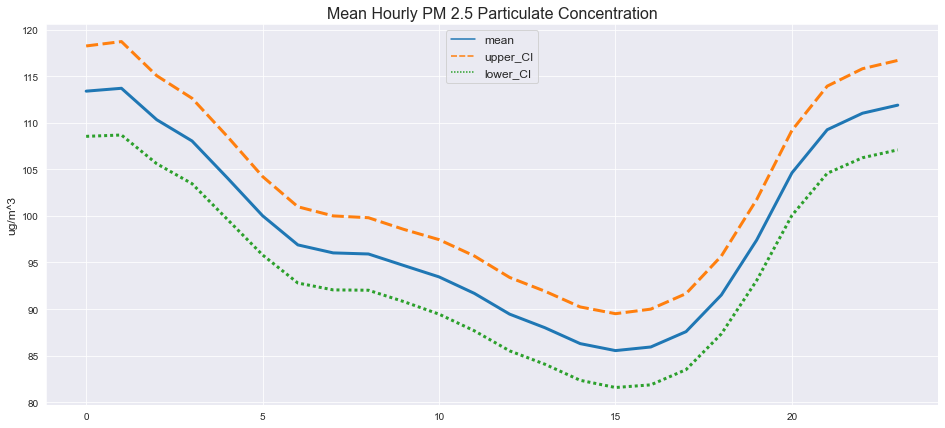

In [28]:
hour_avg = seasonal_mean(df, 'hour', 'pm25')

fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=hour_avg, ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Mean Hourly PM 2.5 Particulate Concentration', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

#### There is a general downward trend in the average PM2.5 between midnight and 15:00, and an upward trend between 15:00 and 23:00

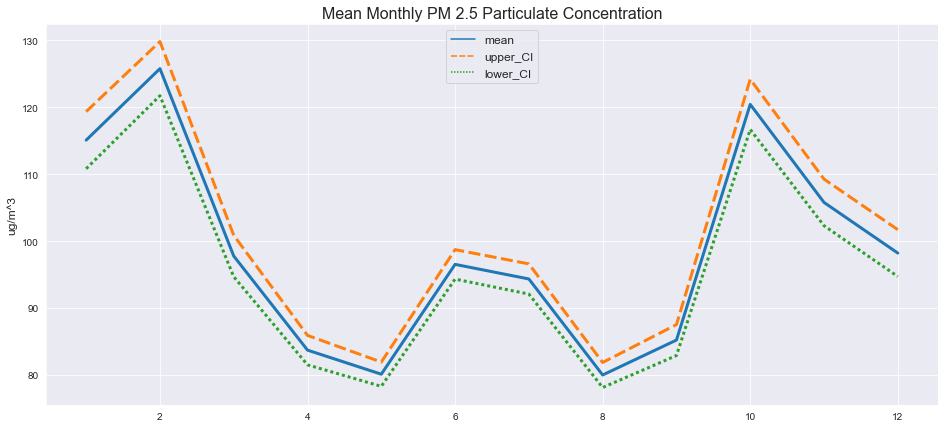

In [29]:
month_avg = seasonal_mean(df, 'month', 'pm25')

fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=month_avg, ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Mean Monthly PM 2.5 Particulate Concentration', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

#### The monhtly average PM2.5 readngs also exhibits seasonality. The readings tend to be low in the warmer months, and higher in the colder months, with pronounced peaks in the average Feb and Oct Readings

### Missing Values

In [30]:
df.isnull().sum()

number       0
year         0
month        0
day          0
hour         0
pm25      2067
dewp         0
temp         0
pres         0
cbwd         0
cws          0
cs           0
cr           0
dtype: int64

#### It happens that the target variable is the only one that has missing variables. Let's check where these missing target variable values are located...

In [31]:
# The very first day of the sample is missing the target variable. 
df.loc[(df.index.month==1) & (df.index.year==2010)].isnull().sum()

number     0
year       0
month      0
day        0
hour       0
pm25      91
dewp       0
temp       0
pres       0
cbwd       0
cws        0
cs         0
cr         0
dtype: int64

In [32]:
df.loc[df.index.year==2010].isnull().sum()

number      0
year        0
month       0
day         0
hour        0
pm25      669
dewp        0
temp        0
pres        0
cbwd        0
cws         0
cs          0
cr          0
dtype: int64

In [33]:
df.loc[df.index.year==2011].isnull().sum()

number      0
year        0
month       0
day         0
hour        0
pm25      728
dewp        0
temp        0
pres        0
cbwd        0
cws         0
cs          0
cr          0
dtype: int64

#### Almost 5% of the PM2.5 are missing observations. Of these, over two-thirds are from the first two years, namely 2010 & 2011. 

#### This weather related data has both intra-day and monthly seasonalities, so a simple linear interpolation or overall mean replacement of the missing values is inappropraite. Even further inappropriate because of the outliers in the data. 

#### Moreover, trying to fill in thes missing values by using estimates of its relationship with the other variables, say through linear or tree-based models, is problematic because it would generate target values that are automatically related to the explanatory variables.

#### Therefore, it is best to proceed as follows:
 #### - Delete the first days (1 Jan 2010) observations, which are entirely NaNs.
 #### - Interpolate inside missing values when there are observations between 0:00 and 14:00 (inclusive) on each day, and then observations between 15:00 and 23:00 (inclusive) on each day. This two-step procedure respects the intra-day seasonality in the data
 #### - Fill in the remaining missing target values by the median of the available data grouped by month and hour

In [34]:
# Deleting observations from 1 January 2010
df = df.iloc[24:]

#### Setting the two time sections, the first covering the hourly PM2.5 downtrend through 14:00 and the second the uptrend starting 15:00

In [35]:
# Intraday downtrend portion
df_down = df.iloc[df.index.indexer_between_time(start_time="00:00", end_time="14:00")]

In [36]:
# Intraday uptrend portion
df_up = df.iloc[df.index.indexer_between_time(start_time="15:00", end_time="23:00")]

In [37]:
df_down['pm25_imp'] = df_down.groupby(['year', 'month', 'day'])['pm25'].apply(lambda x: 
                                                                              x.interpolate(method='linear', 
                                                                                            limit_area='inside'))

In [38]:
df_up['pm25_imp'] = df_up.groupby(['year', 'month', 'day'])['pm25'].apply(lambda x: 
                                                                          x.interpolate(method='linear', 
                                                                                        limit_area='inside'))

In [39]:
df = pd.concat([df_down, df_up])
df.sort_index(inplace=True)

In [40]:
df[['pm25', 'pm25_imp']].describe()

,pm25,pm25_imp
count,41757.000000,41979.000000
mean,98.613215,98.697968
std,92.050387,92.147419
min,0.000000,0.000000
25%,29.000000,29.000000
50%,72.000000,72.000000
75%,137.000000,137.000000
max,994.000000,994.000000


#### Now, we need to fill up the remaining missing values by the hourly median according to each calender month for each year

In [41]:
df['pm25_imp_10'] = df[df.index.year==2010].groupby(['month', 'hour'])['pm25_imp'].transform(lambda x:
                                                                                             x.fillna(x.median()))

In [42]:
df['pm25_imp_11'] = df[df.index.year==2011].groupby(['month', 'hour'])['pm25_imp'].transform(lambda x:
                                                                                             x.fillna(x.median()))

In [43]:
df['pm25_imp_12'] = df[df.index.year==2012].groupby(['month', 'hour'])['pm25_imp'].transform(lambda x:
                                                                                             x.fillna(x.median()))

In [44]:
df['pm25_imp_13'] = df[df.index.year==2013].groupby(['month', 'hour'])['pm25_imp'].transform(lambda x:
                                                                                             x.fillna(x.median()))

In [45]:
df['pm25_imp_14'] = df[df.index.year==2014].groupby(['month', 'hour'])['pm25_imp'].transform(lambda x:
                                                                                             x.fillna(x.median()))

In [46]:
df['pm25_imp_10'] = df['pm25_imp_10'].fillna(df.pm25_imp_11)

In [47]:
df['pm25_imp_10'] = df['pm25_imp_10'].fillna(df.pm25_imp_12)

In [48]:
df['pm25_imp_10'] = df['pm25_imp_10'].fillna(df.pm25_imp_13)

In [49]:
df['pm25_imp_10'] = df['pm25_imp_10'].fillna(df.pm25_imp_14)

In [50]:
df['pm25_imp'] = df['pm25_imp_10']

In [51]:
df[['pm25', 'pm25_imp']].describe()

,pm25,pm25_imp
count,41757.000000,43800.000000
mean,98.613215,98.032767
std,92.050387,90.519946
min,0.000000,0.000000
25%,29.000000,30.000000
50%,72.000000,74.000000
75%,137.000000,134.000000
max,994.000000,994.000000


In [52]:
df['pm25'] = df['pm25_imp']

In [53]:
df.drop(['pm25_imp', 'pm25_imp_10', 'pm25_imp_11', 'pm25_imp_12', 'pm25_imp_13', 
         'pm25_imp_14'], axis=1, inplace=True)

In [54]:
# Converting the float values to integer
df['pm25'] = df['pm25'].astype('int64')
df['temp'] = df['temp'].astype('int64')
df['pres'] = df['pres'].astype('int64')

### Seasonalities in the Data

#### There appears to be daily and monthly seasonalities in the data

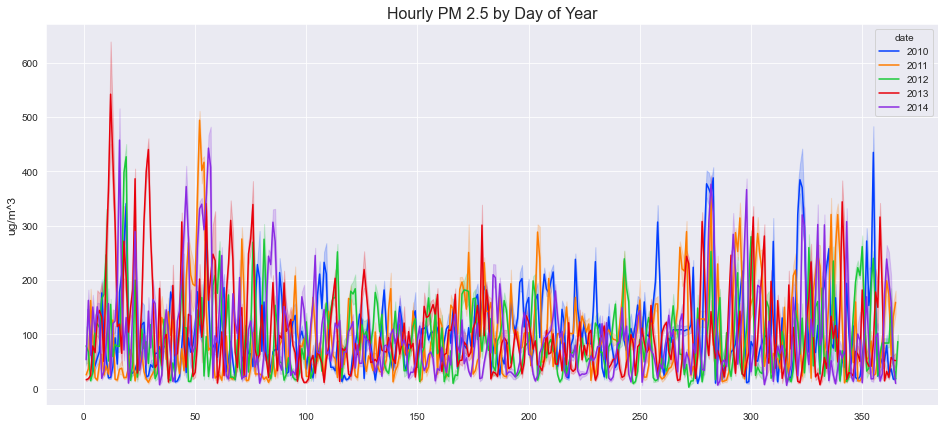

In [55]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(x = df.index.dayofyear, 
             y = df['pm25'], 
             hue = df.index.year,
             palette = sns.color_palette("bright", 5),
             ax = ax)

plt.xlabel('', fontsize=12)
plt.ylabel('ug/m^3', fontsize=12)
plt.title('Hourly PM 2.5 by Day of Year', fontsize=16);

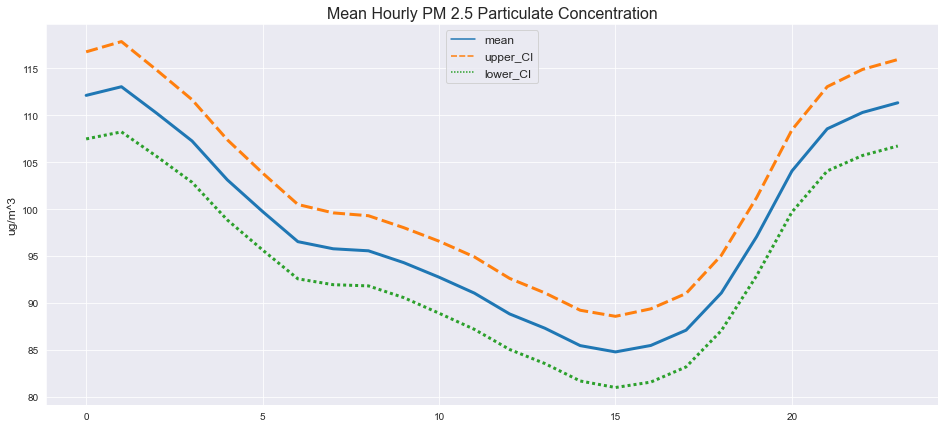

In [56]:
hour_avg = seasonal_mean(df, 'hour', 'pm25')

fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=hour_avg, ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Mean Hourly PM 2.5 Particulate Concentration', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

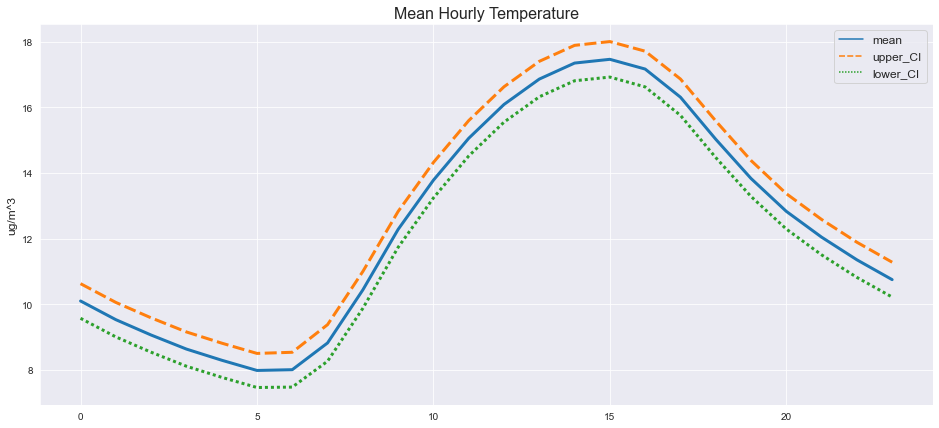

In [57]:
hour_avg = seasonal_mean(df, 'hour', 'temp')

fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=hour_avg, ax=ax, linewidth=3)
plt.legend(loc='upper right', fontsize=12)
plt.title('Mean Hourly Temperature', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

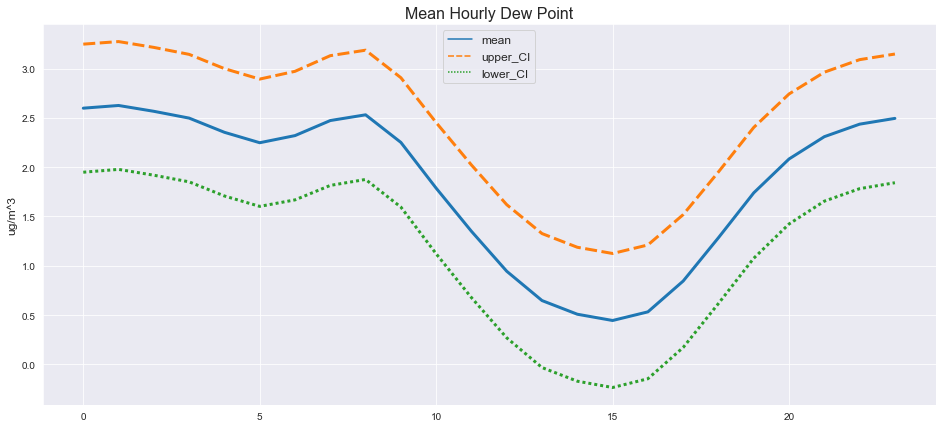

In [58]:
hour_avg = seasonal_mean(df, 'hour', 'dewp')

fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=hour_avg, ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Mean Hourly Dew Point', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

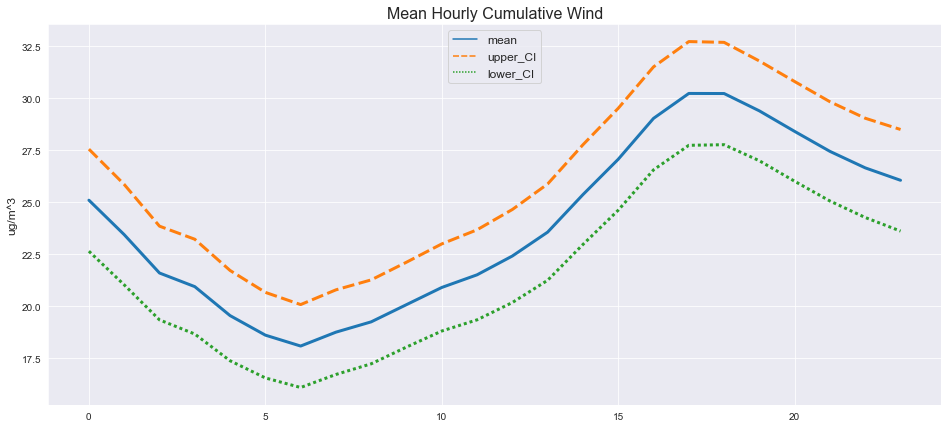

In [59]:
hour_avg = seasonal_mean(df, 'hour', 'cws')

fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=hour_avg, ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Mean Hourly Cumulative Wind', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

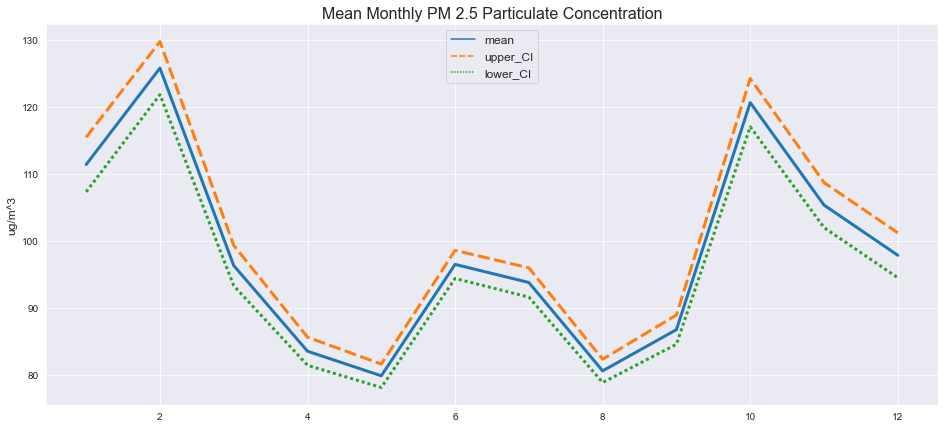

In [60]:
month_avg = seasonal_mean(df, 'month', 'pm25')

fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=month_avg, ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Mean Monthly PM 2.5 Particulate Concentration', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

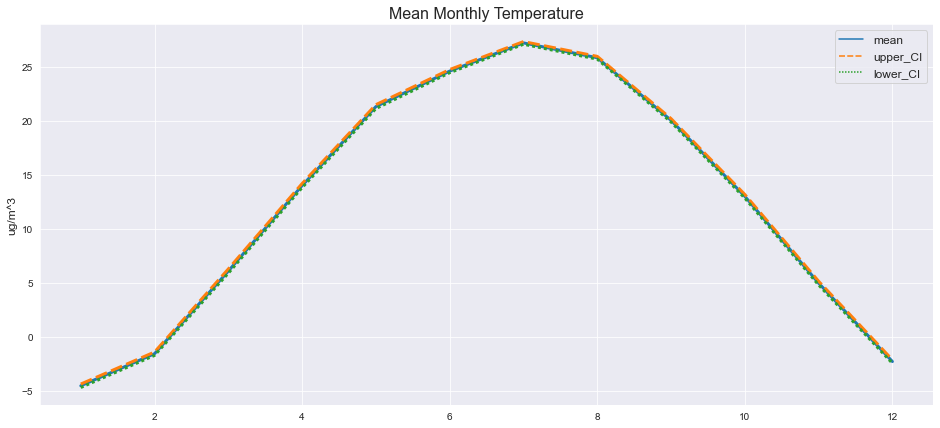

In [61]:
month_avg = seasonal_mean(df, 'month', 'temp')

fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=month_avg, ax=ax, linewidth=3)
plt.legend(loc='upper right', fontsize=12)
plt.title('Mean Monthly Temperature', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

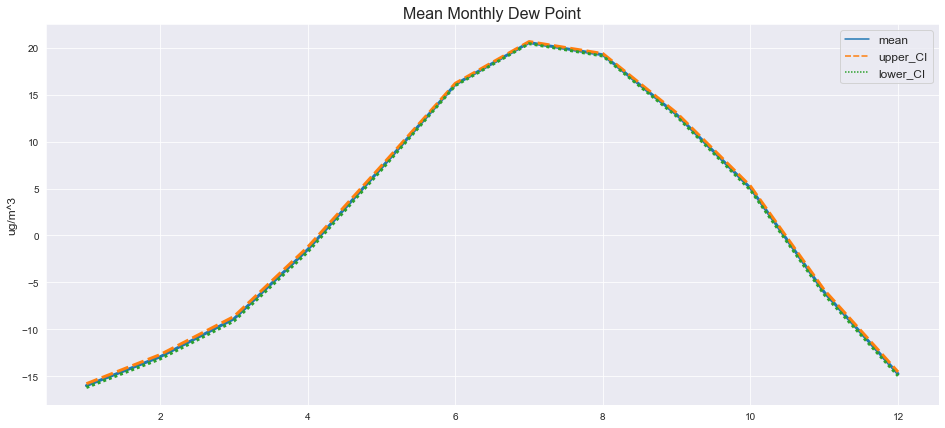

In [62]:
month_avg = seasonal_mean(df, 'month', 'dewp')

fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=month_avg, ax=ax, linewidth=3)
plt.legend(loc='upper right', fontsize=12)
plt.title('Mean Monthly Dew Point', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

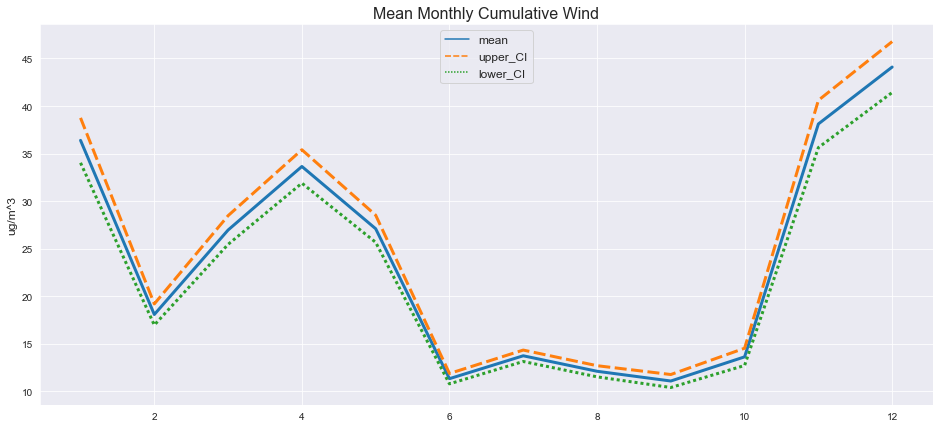

In [63]:
month_avg = seasonal_mean(df, 'month', 'cws')

fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=month_avg, ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Mean Monthly Cumulative Wind', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

### Data Preparation

#### Create the "target" variable that is the one-period-ahead PM2.5 reading

In [68]:
# Generate the target variable
df['target'] = df['pm25'].shift(-1)

#### Create a lunar new year holiday period dummy variable, covering the 7 hours from 21:00 on new year eve through 3:00 on new year day.

In [69]:
df['lunar_2010'] = ((df.index >= '2010-02-13 21:00:00') & (df.index < '2010-02-14 04:00:00')).astype(int)

In [70]:
df['lunar_2011'] = ((df.index >= '2011-02-02 21:00:00') & (df.index < '2011-02-03 04:00:00')).astype(int)

In [71]:
df['lunar_2012'] = ((df.index >= '2012-01-22 21:00:00') & (df.index < '2012-01-23 04:00:00')).astype(int)

In [72]:
df['lunar_2013'] = ((df.index >= '2013-02-09 21:00:00') & (df.index < '2013-02-10 04:00:00')).astype(int)

In [73]:
df['lunar_2014'] = ((df.index >= '2014-01-30 21:00:00') & (df.index < '2014-01-31 04:00:00')).astype(int)

In [74]:
df['lunar'] = df.lunar_2010 + df.lunar_2011 + df.lunar_2012 + df.lunar_2013 + df.lunar_2014

In [75]:
df.drop(['lunar_2010', 'lunar_2011', 'lunar_2012', 'lunar_2013', 'lunar_2014'], axis=1, inplace=True)

#### Create a series of sandstrom dummies. Basically we can see what dates appear on the first page of a google search from "Beigin sandstorm [year]", and record those dates for the dummy. There were 6 days that experienced a "serious" sandstorm in 2010-2014 from the search procedure.

In [76]:
df['storm_2010'] = ((df.index == '2010-03-20') & (df.index == '2010-03-22')).astype(int)

In [77]:
df['storm_2011'] = (df.index == '2011-03-30').astype(int)

In [78]:
df['storm_2013'] = ((df.index == '2013-02-28') & (df.index == '2010-03-08')).astype(int)

In [79]:
df['storm_2014'] = (df.index == '2014-04-09').astype(int)

In [80]:
df['storm'] = df.storm_2010 + df.storm_2011 + df.storm_2013 + df.storm_2014

In [81]:
df.drop(['storm_2010', 'storm_2011', 'storm_2013', 'storm_2014'], axis=1, inplace=True)

#### create a weekend dummy

In [82]:
df['wkend'] = (df.index.weekday >= 5).astype(int)

In [83]:
df[['lunar', 'storm', 'wkend']].describe()

,lunar,storm,wkend
count,43800.000000,43800.000000,43800.000000
mean,0.000799,0.000046,0.286027
std,0.028257,0.006757,0.451907
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000


#### We must also encode the categorical data in "cbwd" (wind direction), and generate dummy variables

In [84]:
df['cbwd'] = df.cbwd.factorize()[0]

In [85]:
df[['cbwd']].describe()

,cbwd
count,43800.000000
mean,1.201644
std,1.042741
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,3.000000


In [86]:
df = pd.get_dummies(df, columns=['cbwd'], drop_first=True)

#### create contemporaneous time/seasonal, lunear new year & sandstorm dummy variables. These are concurrent in time with the target variable.

In [87]:
df['cmonth'] = df['month'].shift(-1)
df['chour'] = df['hour'].shift(-1)
df['clunar'] = df['lunar'].shift(-1)
df['cstorm'] = df['storm'].shift(-1)
df['cwkend'] = df['wkend'].shift(-1)

#### delete the resulting null values

In [88]:
df = df[~df['target'].isnull()]

#### Correlation Matricies

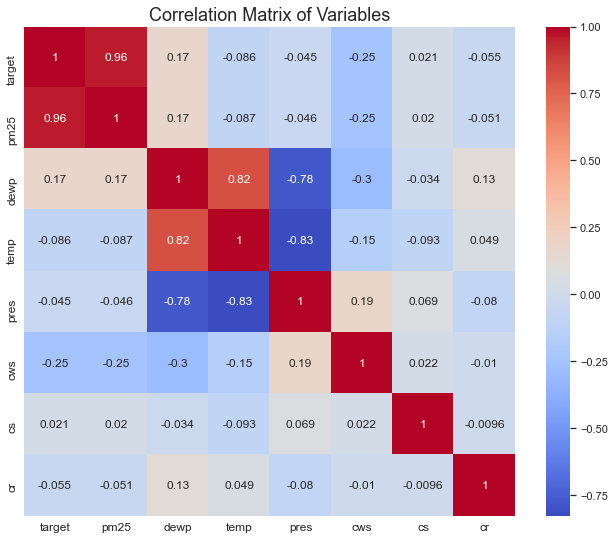

In [89]:
# Generate correlation matrix for the continuous variables
fig, ax = plt.subplots(figsize=(11, 9))

sns.set(font_scale=1.0)
sns.heatmap(df[['target', 'pm25', 'dewp', 'temp', 'pres', 'cws', 'cs', 'cr']].corr(), 
            annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix of Variables", fontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12)
plt.show()

#### There are generally weak correlations between the continuous explanatory variables with the "target" and "PM 2.5" variable one period ahead. Also there are high correlations between "dewp", "temp" and "pres". This will not typically be a problem for machine learning models, but still would prefer a more parmonious model.

#### therefore, we can delete the "cr", "cs" and "pres" variables

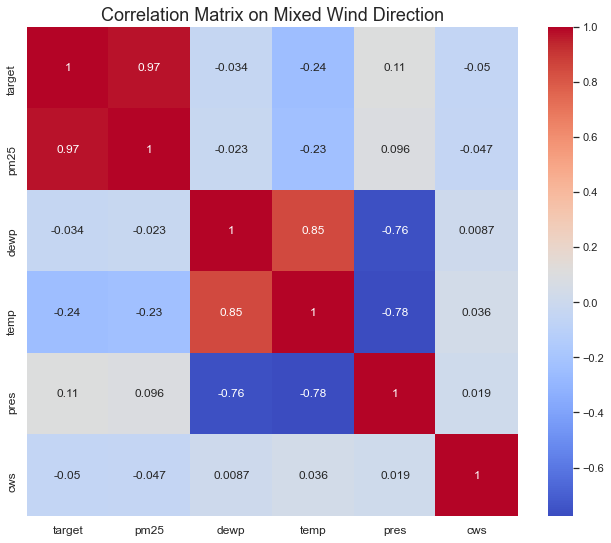

In [90]:
# Generate correlation matrix for the continuous variables under CV wind direction
fig, ax = plt.subplots(figsize=(11, 9))

sns.set(font_scale=1.0)
sns.heatmap(df[['target', 'pm25', 'dewp', 'temp', 'pres', 'cws']][(df.cbwd_1 == 1)].corr(), 
            annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix on Mixed Wind Direction", fontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12)
plt.show()

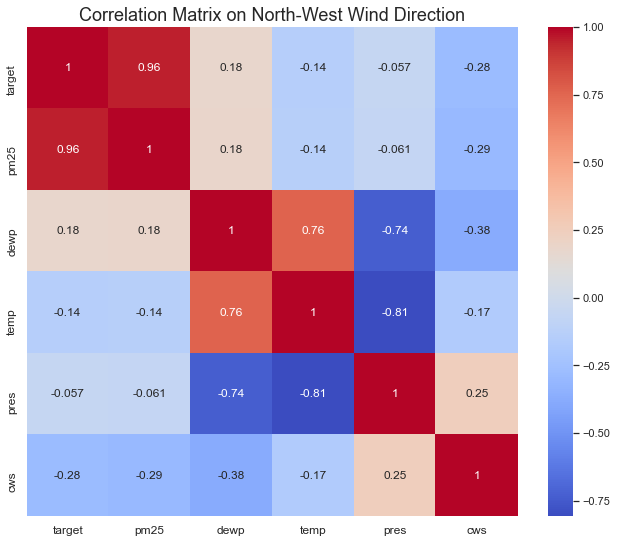

In [91]:
# Generate correlation matrix for the continuous variables under NW wind direction
fig, ax = plt.subplots(figsize=(11, 9))

sns.set(font_scale=1.0)
sns.heatmap(df[['target', 'pm25', 'dewp', 'temp', 'pres', 'cws']][(df.cbwd_2 == 1)].corr(), 
            annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix on North-West Wind Direction", fontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12)
plt.show()

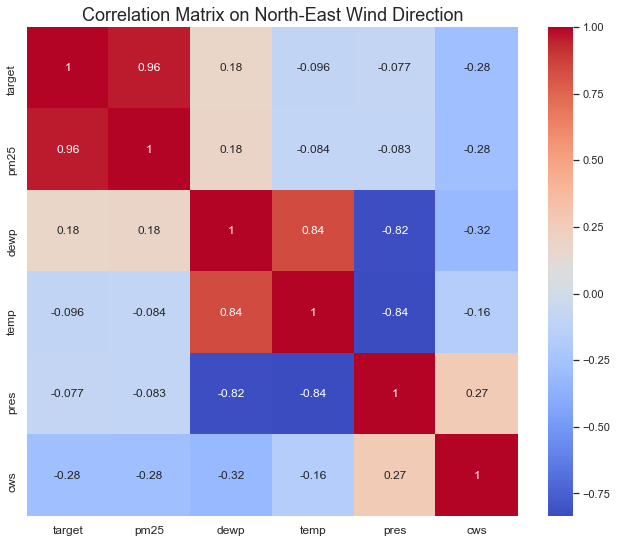

In [92]:
# Generate correlation matrix for the continuous variables under NE wind direction
fig, ax = plt.subplots(figsize=(11, 9))

sns.set(font_scale=1.0)
sns.heatmap(df[['target', 'pm25', 'dewp', 'temp', 'pres', 'cws']][(df.cbwd_3 == 1)].corr(), 
            annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix on North-East Wind Direction", fontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12)
plt.show()

#### Create interaction term between cumulative wind speed and northerly wind speed direction (Mongolian Winds bring dust storms)

In [93]:
df['nord_cws'] = (df.cbwd_2 * df.cws) + (df.cbwd_3 * df.cws)

#### Miscellaneous

In [94]:
# Dropping unnecessary and redundant variables...
df.drop(['year', 'month', 'day', 'hour', 'number', 'cr', 'cs', 'pres', 
         'lunar', 'storm', 'wkend'], axis=1, inplace=True)

In [95]:
df['date'] = df.index

In [96]:
# Transform the contemporaneous month and hour categorical variables into dummies
df = pd.get_dummies(df, columns=['cmonth', 'chour'], drop_first=True)

In [98]:
df.describe()

,pm25,dewp,temp,cws,target,cbwd_1,cbwd_2,cbwd_3,clunar,cstorm,...,chour_14.0,chour_15.0,chour_16.0,chour_17.0,chour_18.0,chour_19.0,chour_20.0,chour_21.0,chour_22.0,chour_23.0
count,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,...,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000
mean,98.027215,1.829037,12.459371,23.889148,98.024544,0.214251,0.322587,0.114067,0.000799,0.000046,...,0.041668,0.041668,0.041668,0.041668,0.041668,0.041668,0.041668,0.041668,0.041668,0.041668
std,90.520772,14.429079,12.193299,50.011647,90.521584,0.410307,0.467472,0.317896,0.028257,0.006757,...,0.199831,0.199831,0.199831,0.199831,0.199831,0.199831,0.199831,0.199831,0.199831,0.199831
min,0.000000,-40.000000,-19.000000,0.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,-10.000000,2.000000,1.790000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,74.000000,2.000000,14.000000,5.370000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,134.000000,15.000000,23.000000,21.910000,134.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,994.000000,28.000000,42.000000,585.600000,994.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Autocorrelation Analysis

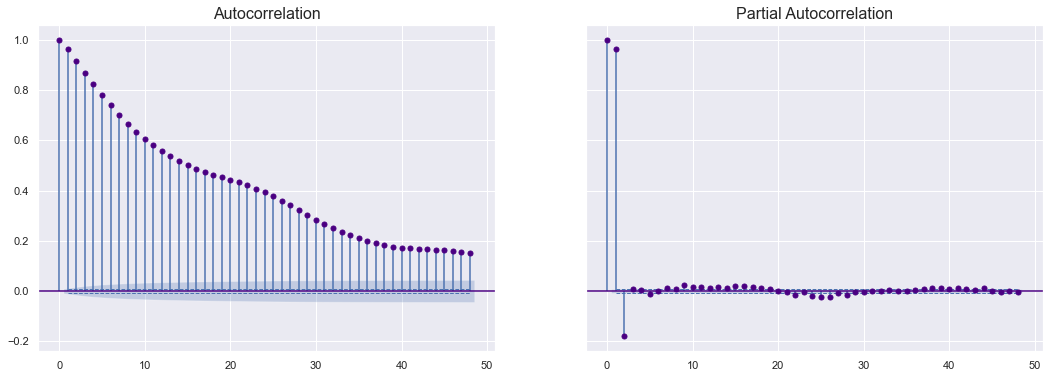

In [99]:
fig, ax = autocorr_plots(df.pm25, lags=48)

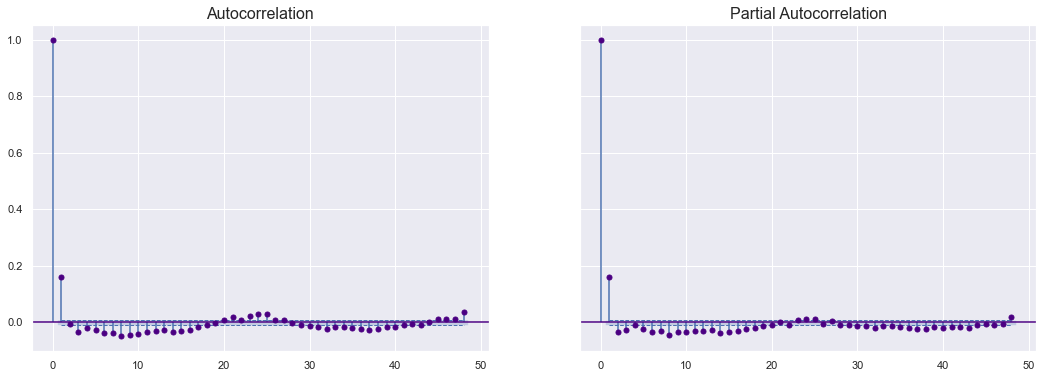

In [100]:
# One differencing should be enough to render PM 2.5 stationary
fig, ax = autocorr_plots(df.pm25.diff()[1:], lags=48)

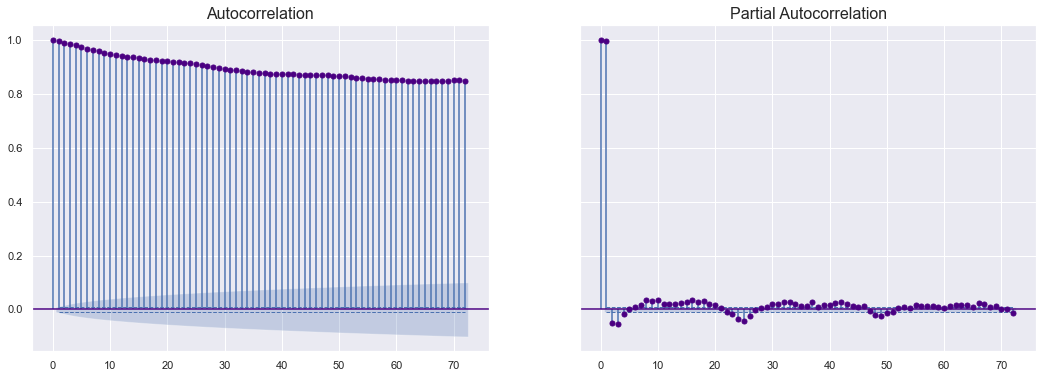

In [101]:
fig, ax = autocorr_plots(df.dewp, lags=72)

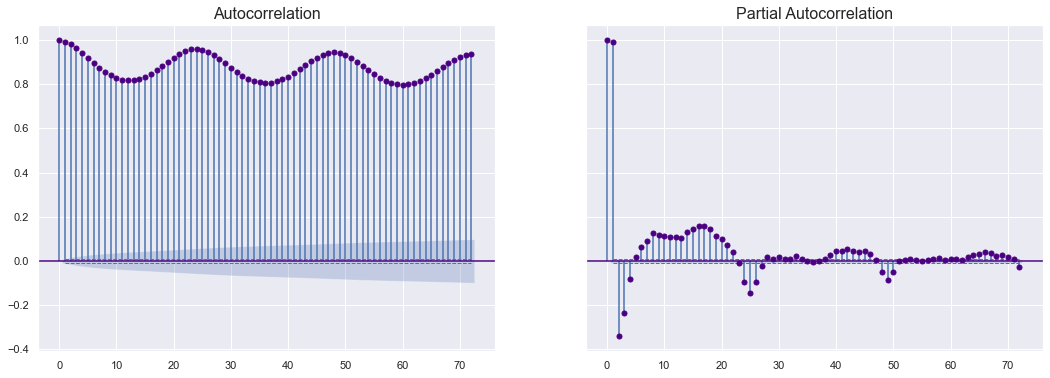

In [102]:
fig, ax = autocorr_plots(df.temp, lags=72)

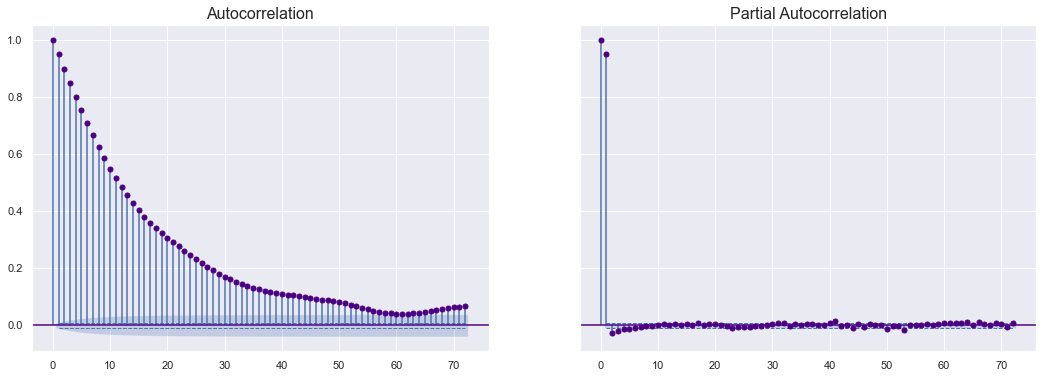

In [103]:
fig, ax = autocorr_plots(df.cws, lags=72)

In [104]:
# Auto-select the best ARMA model up to the first test period, and setting a constant term given no-differencing
auto_select = stattools.arma_order_select_ic(df.pm25, max_ar=20, max_ma=0, ic=['aic', 'bic'], trend='c')

print(auto_select)

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


{'aic':                 0
0   518978.917261
1   402857.940058
2   401394.803796
3   401393.407447
4   401394.873075
5   401389.542640
6   401391.518317
7   401388.064255
8   401387.410123
9   401366.697798
10  401357.873678
11  401346.416937
12  401341.201794
13  401334.093647
14  401329.218139
15  401311.340590
16  401297.079189
17  401286.087924
18  401282.380505
19  401281.888258
20  401283.819347, 'bic':                 0
0   518996.291994
1   402884.002157
2   401429.553261
3   401436.844278
4   401446.997273
5   401450.354204
6   401461.017247
7   401466.250551
8   401474.283785
9   401462.258827
10  401462.122073
11  401459.352699
12  401462.824921
13  401464.404141
14  401468.215999
15  401459.025817
16  401453.451782
17  401451.147883
18  401456.127831
19  401464.322949
20  401474.941404, 'aic_min_order': (19, 0), 'bic_min_order': (2, 0)}


#### The optimal AR order is found to be 2 lags for BIC and 19 lags for AIC. It is interesting that the AIC score hits an initial low at 3 lags before dropping again at 19 lags.

#### Given persistently high autocorrelation seen in the ACF plot, one is tempted to use more lags, but lets go with the BIC scoring +1(the intitial AIC bottom) to make the model more parsimonious, so 3 lags.

In [105]:
# Generate 2 additional lags of the "PM 2.5" variable
for i in range(1,3):
    df['pm25_{0}'.format(i)] = df.pm25.shift(i)

In [106]:
# Delete all NaN value rows
df = df[~df['pm25_2'].isnull()]

In [107]:
df['cws'] = df['cws'].astype('int64')
df['clunar'] = df['clunar'].astype('int')
df['cstorm'] = df['cstorm'].astype('int')
df['cwkend'] = df['cwkend'].astype('int')
df['nord_cws'] = df['nord_cws'].astype('int64')
df['pm25_1'] = df['pm25_1'].astype('int64')
df['pm25_2'] = df['pm25_2'].astype('int64')
df['target'] = df['target'].astype('int64')

In [108]:
target_test = df.iloc[-438:]['target']
lag_test = df.iloc[-438:]['pm25']

In [109]:
exp_target = target_test
exp_lag = lag_test

In [110]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print('Persistence MAE:', round(mean_absolute_error(exp_target, exp_lag), 4))
print('Persistence RMSE:', round(mean_squared_error(exp_target, exp_lag, squared=False), 4))

Persistence MAE: 14.8037
Persistence RMSE: 27.9379


In [111]:
df.isnull().values.any()

False

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43797 entries, 2010-01-02 02:00:00 to 2014-12-31 22:00:00
Data columns (total 49 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   pm25         43797 non-null  int64         
 1   dewp         43797 non-null  int64         
 2   temp         43797 non-null  int64         
 3   cws          43797 non-null  int64         
 4   target       43797 non-null  int64         
 5   cbwd_1       43797 non-null  uint8         
 6   cbwd_2       43797 non-null  uint8         
 7   cbwd_3       43797 non-null  uint8         
 8   clunar       43797 non-null  int32         
 9   cstorm       43797 non-null  int32         
 10  cwkend       43797 non-null  int32         
 11  nord_cws     43797 non-null  int64         
 12  date         43797 non-null  datetime64[ns]
 13  cmonth_2.0   43797 non-null  uint8         
 14  cmonth_3.0   43797 non-null  uint8         
 15  cmonth_4.0   43797

In [113]:
# Saving engineered dataset for Stack and XGboost modelling
df.to_csv('pollution_fromscript.csv', index=False)